In [1]:
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from os.path import isfile, join
import random

from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import layers
from tensorflow.keras import metrics

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from google.colab import files
from tensorflow.keras.preprocessing import image
import zipfile
import os
import gdown

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
DIR = "/content/drive/MyDrive/Colab Notebooks/IEEE Executive Project 2022/archive/lgg-mri-segmentation/kaggle_3m"
INPUT_CHANNELS = 3
TARGET_CHANNELS = 1
SIZE = 256
BATCH_SIZE = 32

In [4]:
mri_images_with_tumer = []
mri_images_without_tumer = []
mask_images_with_tumer = []
mask_images_without_tumer = []

patients = os.listdir(DIR)
for patient in tqdm(patients):
    if isfile(join(DIR, patient)) == False:
        images = os.listdir(join(DIR, patient))
        mask_images = list(filter(lambda x: x.find('mask') != -1, images))
        mri_images = list(filter(lambda x: x.find('mask') == -1, images))
        
        for mask_image in mask_images:
            mask = np.asarray(load_img(
                join(DIR, patient, mask_image), 
                target_size=(SIZE, SIZE), 
                color_mode="grayscale"))
            if np.amax(mask) != 0:
                mri_images_with_tumer.append(join(patient, mask_image.replace('_mask', '')))
                mask_images_with_tumer.append(join(patient, mask_image))
            else:
                mri_images_without_tumer.append(join(patient, mask_image.replace('_mask', '')))
                mask_images_without_tumer.append(join(patient, mask_image))

100%|██████████| 113/113 [08:55<00:00,  4.74s/it]


Total MRI images:  3929
Total mask images:  3929
Total images with tumer:  1373
Total images without tumer:  2556


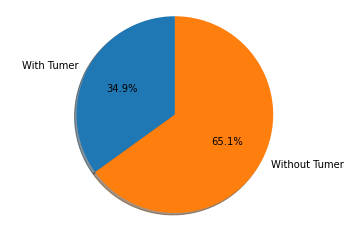

In [5]:
random.Random(1337).shuffle(mri_images_with_tumer)
random.Random(1337).shuffle(mask_images_with_tumer)
random.Random(1337).shuffle(mri_images_without_tumer)
random.Random(1337).shuffle(mask_images_without_tumer)


print("Total MRI images: ", len(mri_images_with_tumer) + len(mri_images_without_tumer))
print("Total mask images: ", len(mask_images_with_tumer) + len(mask_images_without_tumer))
print("Total images with tumer: ", len(mri_images_with_tumer))
print("Total images without tumer: ", len(mri_images_without_tumer))

labels = ['With Tumer', 'Without Tumer']
count = [len(mri_images_with_tumer), len(mri_images_without_tumer)]

fig, ax = plt.subplots()
ax.pie(count, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [6]:
mri_images_with_tumer = np.array(mri_images_with_tumer)
mri_images_without_tumer = np.array(mri_images_without_tumer)
mask_images_with_tumer = np.array(mask_images_with_tumer)
mask_images_without_tumer = np.array(mask_images_without_tumer)

In [7]:
with_tumer_val_images = 300
without_tumer_val_images = 600

with_tumer_test_images = 10
without_tumer_test_images = 5

train_images = np.concatenate(
    (mri_images_with_tumer[:-with_tumer_val_images-with_tumer_test_images], 
     mri_images_without_tumer[:-without_tumer_val_images-without_tumer_test_images]), 
    axis = 0)

val_images = np.concatenate(
    (mri_images_with_tumer[-with_tumer_val_images-with_tumer_test_images:-with_tumer_test_images], 
     mri_images_without_tumer[-without_tumer_val_images-without_tumer_test_images:-without_tumer_test_images]), 
    axis = 0)

test_images = np.concatenate(
    (mri_images_with_tumer[-with_tumer_test_images:], 
     mri_images_without_tumer[-without_tumer_test_images:]), 
    axis = 0)

train_targets = np.concatenate(
    (mask_images_with_tumer[:-with_tumer_val_images-with_tumer_test_images], 
     mask_images_without_tumer[:-without_tumer_val_images-without_tumer_test_images]), 
    axis = 0)

val_targets = np.concatenate(
    (mask_images_with_tumer[-with_tumer_val_images-with_tumer_test_images:-with_tumer_test_images], 
     mask_images_without_tumer[-without_tumer_val_images-without_tumer_test_images:-without_tumer_test_images]), 
    axis = 0)

test_targets = np.concatenate(
    (mask_images_with_tumer[-with_tumer_test_images:], 
     mask_images_without_tumer[-without_tumer_test_images:]), 
    axis = 0)


print("train_images: ", train_images.shape)
print("train_targets: ", train_targets.shape)
print("val_images: ", val_images.shape)
print("val_targets: ", val_targets.shape)
print("test_images: ", test_images.shape)
print("test_targets: ", test_targets.shape)

train_images:  (3014,)
train_targets:  (3014,)
val_images:  (900,)
val_targets:  (900,)
test_images:  (15,)
test_targets:  (15,)


In [8]:
random.Random(37).shuffle(train_images)
random.Random(37).shuffle(train_targets)
random.Random(37).shuffle(val_images)
random.Random(37).shuffle(val_targets)

In [9]:
train_df = pd.DataFrame(data={'mris': train_images, 'masks': train_targets})
val_df = pd.DataFrame(data={'mris': val_images, 'masks': val_targets})
test_df = pd.DataFrame(data={'mris': test_images, 'masks': test_targets})

In [10]:
plt.figure(figsize=(30,60))

for j in range(0, 10):
    index = random.randrange(0, 1000, 3)
    
    mri = np.asarray(load_img(
         join(DIR, train_df['mris'][index]), 
         target_size=(SIZE, SIZE)))
    mask = np.asarray(load_img(
        join(DIR, train_df['masks'][index]), 
        target_size=(SIZE, SIZE), 
        color_mode="grayscale"))
             
    images = [mri, mri[:,:,0], mri[:,:,1], mri[:,:,2], mask]
    titles = ["RBG Image", "Pre Contrast", "FLAIR", "Post Contrast", "Mask"]
    
    for i in range(0, 5):
        ax = plt.subplot(10, 5, (j*5)+i+1)
        ax.set_title(titles[i], fontsize = 16)
        plt.imshow(X=images[i], cmap='gray')

plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [11]:
plt.figure(figsize=(30,60))

for j in range(0, 10):
    index = random.randrange(0, 200, 3)
    
    mri = np.asarray(load_img(
         join(DIR, val_df['mris'][index]), 
         target_size=(SIZE, SIZE)))
    mask = np.asarray(load_img(
        join(DIR, val_df['masks'][index]), 
        target_size=(SIZE, SIZE), 
        color_mode="grayscale"))
             
    images = [mri, mri[:,:,0], mri[:,:,1], mri[:,:,2], mask]
    titles = ["RBG Image", "Pre Contrast", "FLAIR", "Post Contrast", "Mask"]
    
    for i in range(0, 5):
        ax = plt.subplot(10, 5, (j*5)+i+1)
        ax.set_title(titles[i], fontsize = 16)
        plt.imshow(X=images[i], cmap='gray')

plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [12]:
def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

class BrainMRIs(keras.utils.Sequence):

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths, directory):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        self.directory = directory

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]

        x = np.zeros((self.batch_size, self.img_size, self.img_size, 3), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(join(self.directory, path), target_size=(self.img_size, self.img_size))
            x[j] = img
            
        y = np.zeros((self.batch_size, self.img_size, self.img_size, 1), dtype="float32")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(join(self.directory, path), target_size=(self.img_size, self.img_size), color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
        
        return adjust_data(x, y)

In [13]:
train_gen = BrainMRIs(BATCH_SIZE, SIZE, train_images, train_targets, DIR)
val_gen = BrainMRIs(BATCH_SIZE, SIZE, val_images, val_targets, DIR)
test_gen = BrainMRIs(BATCH_SIZE, SIZE, test_images, test_targets, DIR)

In [14]:
smooth=100

def dice_coef(y_true, y_pred):
    y_truef = keras.backend.flatten(y_true)
    y_predf = keras.backend.flatten(y_pred)
    And = keras.backend.sum(y_truef*y_predf)
    return((2* And + smooth) / (keras.backend.sum(y_truef) + keras.backend.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = keras.backend.sum(y_true * y_pred)
    sum_ = keras.backend.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def jac_distance(y_true, y_pred):
    y_truef = keras.backend.flatten(y_true)
    y_predf = keras.backend.flatten(y_pred)

    return - iou(y_true, y_pred)

In [15]:
keras.backend.clear_session()

In [16]:
inputs = layers.Input((SIZE, SIZE, INPUT_CHANNELS))

c1 = layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', name='conv1_1')(inputs)
c1 = layers.Dropout(0.2)(c1)
c1 = layers.Conv2D(32, kernel_size=(3, 3), padding='same', name="conv1_2")(c1)
c1 = layers.BatchNormalization(axis=3)(c1)
c1 = layers.Activation('relu')(c1)
input_1 = layers.MaxPooling2D((2, 2))(c1)

c2 = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', name='conv2_1')(input_1)
c2 = layers.Dropout(0.2)(c2)
c2 = layers.Conv2D(64, kernel_size=(3, 3), padding='same', name="conv2_2")(c2)
c2 = layers.BatchNormalization(axis=3)(c2)
c2 = layers.Activation('relu')(c2)
input_2 = layers.MaxPooling2D((2, 2))(c2)

c3 = layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', name='conv3_1')(input_2)
c3 = layers.Dropout(0.2)(c3)
c3 = layers.Conv2D(128, kernel_size=(3, 3), padding='same', name="conv3_2")(c3)
c3 = layers.BatchNormalization(axis=3)(c3)
c3 = layers.Activation('relu')(c3)
input_3 = layers.MaxPooling2D((2, 2))(c3)

c4 = layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', name='conv4_1')(input_3)
c4 = layers.Dropout(0.2)(c4)
c4 = layers.Conv2D(256, kernel_size=(3, 3), padding='same', name="conv4_2")(c4)
c4 = layers.BatchNormalization(axis=3)(c4)
c4 = layers.Activation('relu')(c4)
input_4 = layers.MaxPooling2D((2, 2))(c4)

c5 = layers.Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', name='conv5_1')(input_4)
c5 = layers.Dropout(0.2)(c5)
c5 = layers.Conv2D(512, kernel_size=(3, 3), padding='same', name="conv5_2")(c5)
c5 = layers.BatchNormalization(axis=3)(c5)
c5 = layers.Activation('relu')(c5)

u6 = layers.Conv2DTranspose(256, kernel_size=(2, 2), strides=(2, 2), activation='relu', padding='same', name='conv6_1')(c5)
u6 = layers.concatenate([u6, c4])
c6 = layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', name='conv6_2')(u6)
c6 = layers.Dropout(0.2)(c6)
c6 = layers.Conv2D(256, kernel_size=(3, 3), padding='same', name="conv6_3")(c6)
c6 = layers.BatchNormalization(axis=3)(c6)
c6 = layers.Activation('relu')(c6)

u7 = layers.Conv2DTranspose(128, kernel_size=(2, 2), strides=(2, 2), activation='relu', padding='same', name='conv7_1')(c6)
u7 = layers.concatenate([u7, c3])
c7 = layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', name='conv7_2')(u7)
c7 = layers.Dropout(0.2)(c7)
c7 = layers.Conv2D(128, kernel_size=(3, 3), padding='same', name="conv7_3")(c7)
c7 = layers.BatchNormalization(axis=3)(c7)
c7 = layers.Activation('relu')(c7)

u8 = layers.Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), activation='relu', padding='same', name='conv8_1')(c7)
u8 = layers.concatenate([u8, c2])
c8 = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', name='conv8_2')(u8)
c8 = layers.Dropout(0.2)(c8)
c8 = layers.Conv2D(64, kernel_size=(3, 3), padding='same', name="conv8_3")(c8)
c8 = layers.BatchNormalization(axis=3)(c8)
c8 = layers.Activation('relu')(c8)

u9 = layers.Conv2DTranspose(32, kernel_size=(2, 2), strides=(2, 2), activation='relu', padding='same', name='conv9_1')(c8)
u9 = layers.concatenate([u9, c1])
c9 = layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', name='conv9_2')(u9)
c9 = layers.Dropout(0.2)(c9)
c9 = layers.Conv2D(32, kernel_size=(3, 3), padding='same', name="conv9_3")(c9)
c9 = layers.BatchNormalization(axis=3)(c9)
c9 = layers.Activation('relu')(c9)

outputs = layers.Conv2D(1, kernel_size=(1, 1), activation='sigmoid', padding='same', name="output")(c9)

model = keras.Model(inputs=[inputs], outputs=[outputs])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_1 (Conv2D)               (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 32  0           ['conv1_1[0][0]']                
                                )                                                             

In [17]:
EPOCHS = 30
learning_rate = 1e-2
decay_rate = learning_rate / 10

In [18]:
model.compile(
    optimizer=keras.optimizers.Adam(
        learning_rate=learning_rate, 
        beta_1=0.9, 
        beta_2=0.999, 
        epsilon=None, 
        decay=decay_rate, 
        amsgrad=False), 
    loss=dice_coef_loss,
    metrics=["binary_accuracy", iou, dice_coef])

model_checkpoint = keras.callbacks.ModelCheckpoint('unet_brain_mri_seg.hdf5', verbose=1, save_best_only=True)
#early_stopping  = keras.callbacks.EarlyStopping(min_delta=0.001, patience=5)

history = model.fit(
    train_gen, 
    validation_data=val_gen,
    epochs=100,
    callbacks=[model_checkpoint])

Epoch 1/100
94/94 [==============================] - ETA: 0s - loss: -0.2768 - binary_accuracy: 0.9378 - iou: 0.1748 - dice_coef: 0.2768
Epoch 1: val_loss improved from inf to -0.06952, saving model to unet_brain_mri_seg.hdf5
94/94 [==============================] - 687s 7s/step - loss: -0.2768 - binary_accuracy: 0.9378 - iou: 0.1748 - dice_coef: 0.2768 - val_loss: -0.0695 - val_binary_accuracy: 0.7698 - val_iou: 0.0363 - val_dice_coef: 0.0695
Epoch 2/100
94/94 [==============================] - ETA: 0s - loss: -0.4475 - binary_accuracy: 0.9878 - iou: 0.3022 - dice_coef: 0.4475
Epoch 2: val_loss improved from -0.06952 to -0.24198, saving model to unet_brain_mri_seg.hdf5
94/94 [==============================] - 66s 701ms/step - loss: -0.4475 - binary_accuracy: 0.9878 - iou: 0.3022 - dice_coef: 0.4475 - val_loss: -0.2420 - val_binary_accuracy: 0.9541 - val_iou: 0.1407 - val_dice_coef: 0.2420
Epoch 3/100
94/94 [==============================] - ETA: 0s - loss: -0.4438 - binary_accuracy: 0

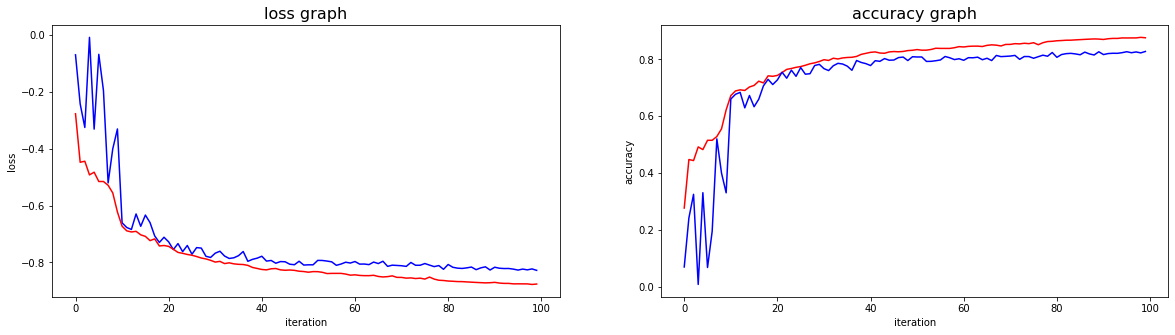

In [19]:
a = history.history

list_trainloss = a['loss']
list_testloss = a['val_loss']
list_traindice = a['dice_coef']
list_testdice = a['val_dice_coef']

plt.figure(figsize=(20,5))

ax = plt.subplot(1, 2, 1)
ax.set_title('loss graph', fontsize = 16)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.plot(list_testloss, 'b-')
plt.plot(list_trainloss,'r-')

ax = plt.subplot(1, 2, 2)
ax.set_title('accuracy graph', fontsize = 16)
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.plot(list_traindice, 'r-')
plt.plot(list_testdice, 'b-')

plt.show()

In [20]:
x = np.zeros((15, SIZE, SIZE, 3), dtype="float32")   
disp_x = np.zeros((15, SIZE, SIZE, 3), dtype="uint8")
y = np.zeros((15, SIZE, SIZE, 1), dtype="uint8")

for j in range(0, 15):
    x[j] = np.asarray(load_img(
         join(DIR, test_df['mris'][j]), 
         target_size=(SIZE, SIZE)))
    disp_x[j] = x[j]
    img = np.asarray(load_img(
        join(DIR, test_df['masks'][j]), 
        target_size=(SIZE, SIZE), 
        color_mode="grayscale"))
    y[j] = np.expand_dims(img, 2)

In [21]:
model = keras.models.load_model('unet_brain_mri_seg.hdf5', custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})
preds = model.predict(x / 255)

In [22]:
preds_t = (preds > 0.5).astype(np.uint8)
print(np.amax(preds))
print(np.amax(preds_t))
print(preds.shape)

print(np.unique(preds_t, return_counts=True))

1.0
1
(15, 256, 256, 1)
(array([0, 1], dtype=uint8), array([967776,  15264]))


TypeError: ignored

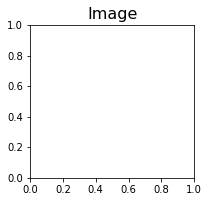

In [24]:
plt.figure(figsize=(10,50))

titles = ["Image", "Original Mask", "Predicted Mask"]

for j in range(15):
    images = [disp_x[j], y[j], preds_t[j]**255]
    for i in range(0, 3):
        ax = plt.subplot(15, 3, (j*3)+i+1)
        ax.set_title(titles[i], fontsize = 16)
        plt.imshow(X=images[i,:,:,0], cmap='gray')
        
plt.tight_layout()
plt.show()